# Finetuning VADER accuracy with Urban Dictionary

## Introduction
You may wish to download the Urban Dictionary dataset yourself from [here](https://www.kaggle.com/datasets/therohk/urban-dictionary-words-dataset) and place it in `datasets`.

For the rest, we opt to use HuggingFace's dataset management.

In [ ]:
# %pip install datasets

In [57]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
plt.rcParams["figure.dpi"] = 200

import os

from math import sqrt, exp
import nltk.sentiment.vader as vader
import pickle
from datasets import load_dataset
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

## Dataframe Loading and Filtering

In [105]:
# Load the urban dict dataset
urbandict: pd.DataFrame = pd.read_csv('datasets/urbandict-word-defs.csv', on_bad_lines='skip')
urbandict = urbandict.astype({"up_votes": str, "down_votes": str})

print("Initial length", urbandict.shape)
urbandict = urbandict.dropna()
print("Length after nan filtering", urbandict.shape)
urbandict = urbandict.loc[urbandict["up_votes"].astype(int) > 20].loc[urbandict["down_votes"].astype(int) > 10]
print("Length after upvote filtering", urbandict.shape)
urbandict = urbandict.groupby('word').agg(
    {'definition': '+=+'.join, 'up_votes': '+=+'.join, 'down_votes': '+=+'.join}).reset_index()
print("Length after aggregation", urbandict.shape)


Initial length (2580590, 6)
Length after nan filtering (2580361, 6)
Length after upvote filtering (639789, 6)
Length after aggregation (302136, 4)


## Finetuning
We use the **Wilson score interval** for finetuning:

$$p \approx \frac{n_S + \frac{1}{2} z^2}{n+z^2} \pm \frac{z}{n+z^2} \sqrt{\frac{n_S n_F}{n} + \frac{z^2}{4}}$$

$p$ - score  
$n_S$ - number of successes  
$n_F$ - number of failures  
$n$ - total  
$z$ - confidence interval (we choose 95% with corresponding 1.96)  

In [106]:
def wilson(up_votes, down_votes, z=1.96):
    """
        Computes the rating of a word based on the up_votes and down_votes
        based on Wilson's score interval.
        
        Default z=1.96 corresponds to 95% confidence interval.
    """
    total = up_votes + down_votes
    z_2 = z**2
    common_term = (up_votes + z_2 /2) / (total + z_2)
    second_term = z * sqrt((up_votes * down_votes) / total + z_2 / 4) / (total + z_2)
    return common_term - second_term, common_term + second_term

def single_score_wilson(up_votes: int, down_votes:int, z:float =1.96) -> float:
    return (up_votes + z**2 / 2) / (( up_votes + down_votes + z**2))


Build up a model using urbandictionary definitions.

In [107]:
def upgrade_lexicon(analyzer: vader.SentimentIntensityAnalyzer, update_df: pd.DataFrame, beta=8) -> dict:
    """
        Updates the lexicon of the analyzer with the words in the upd dataframe.
        
        --- Parameters ---
        
        analyzer: vader.SentimentIntensityAnalyzer
            The analyzer to update.
        upd: pd.DataFrame
            The dataframe containing the words to add to the lexicon.
        beta: float
            The beta parameter of the softmax function which manipulates rankings. Higher value skews the ranking towards higher values and vice versa.
    """
    return_lex = analyzer.lexicon.copy()
    
    for row in update_df.itertuples():
        if row.word.lower() not in analyzer.lexicon:
            # We would like to use the average score of the definitions as the score of the word
            # however, we also want to account for the definition scores
            # Building a metric for that is challenging in its own right and needs to be accounted for.
            # Get back a list of definitions
            definitions = [defi if defi else "" for defi in row.definition.split('+=+')]
            # Build a list of scores for each definition
            description_scores = [analyzer.polarity_scores(text=defi)['compound'] for defi in definitions]
            # Get the wilson score for the word
            scores = [wilson(int(upvote), int(downvote), 1.96)[0] for upvote, downvote in zip(row.up_votes.split('+=+'), row.down_votes.split('+=+'))]
            
            # Get the average score of the definitions using softmax, and apply beta to skew the weights
            weightings = [exp(beta*score) for score in scores]
            return_lex[row.word.lower()] = sum([weight * desc_score for weight, desc_score in zip(weightings, description_scores)]) / sum(weightings)
    return return_lex


Load analyzers or build them anew.

`lex` here refers to the version number of the dictionary used.

Version 1 used a much less aggressive Wilson score (only the first term) and softmax exponent.
Version 2 opted for the lower bound of the Wilson score and $\beta=8$ as softmax parameter to give greater importance to higher rated definitions.

In [120]:
# Default analyzer
analyzer = vader.SentimentIntensityAnalyzer()

# Lexicon file name
lex = 2
urban_lexicon_file = f'urban_lexicon_{lex}.pickle'

# Load the lexicon if it exists
urban_analyzer = vader.SentimentIntensityAnalyzer()
if urban_lexicon_file not in os.listdir(os.path.join(os.getcwd(), "backup")):
    urban_analyzer.lexicon = upgrade_lexicon(analyzer, urbandict)
    with open(os.path.join(os.getcwd(), "backup", urban_lexicon_file), 'wb') as f:
        pickle.dump(urban_analyzer.lexicon, f)
else:
    with open(os.path.join(os.getcwd(), "backup", urban_lexicon_file), 'rb') as f:
        urban_analyzer.lexicon = pickle.load(f)


## Benchmarks

### IMDB scores

In [109]:
from typing import Iterable

def get_imdb_scores(analyzer: vader.SentimentIntensityAnalyzer, urban_analyzer: vader.SentimentIntensityAnalyzer, ds: Iterable) -> pd.DataFrame:
    results = []
    for row in ds:
        results.append((analyzer.polarity_scores(row["text"]), urban_analyzer.polarity_scores(row["text"]), row["label"]))
    return pd.DataFrame(results, columns=["Vader", "Urban", "True"])


imdb_ds = load_dataset('imdb', split='test')
imdb_results = get_imdb_scores(analyzer, urban_analyzer, imdb_ds)


Found cached dataset imdb (/Users/Matey/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


\begin{table}
\caption{IMDB Sentiment}
\label{tab:imdb}
\begin{tabular}{lrrrr}
\toprule
 & Precision & Recall & F1 Score & Accuracy \\
\midrule
VL & 0.650 & 0.860 & 0.740 & 0.698 \\
UDL & 0.627 & 0.878 & 0.731 & 0.678 \\
\bottomrule
\end{tabular}
\end{table}



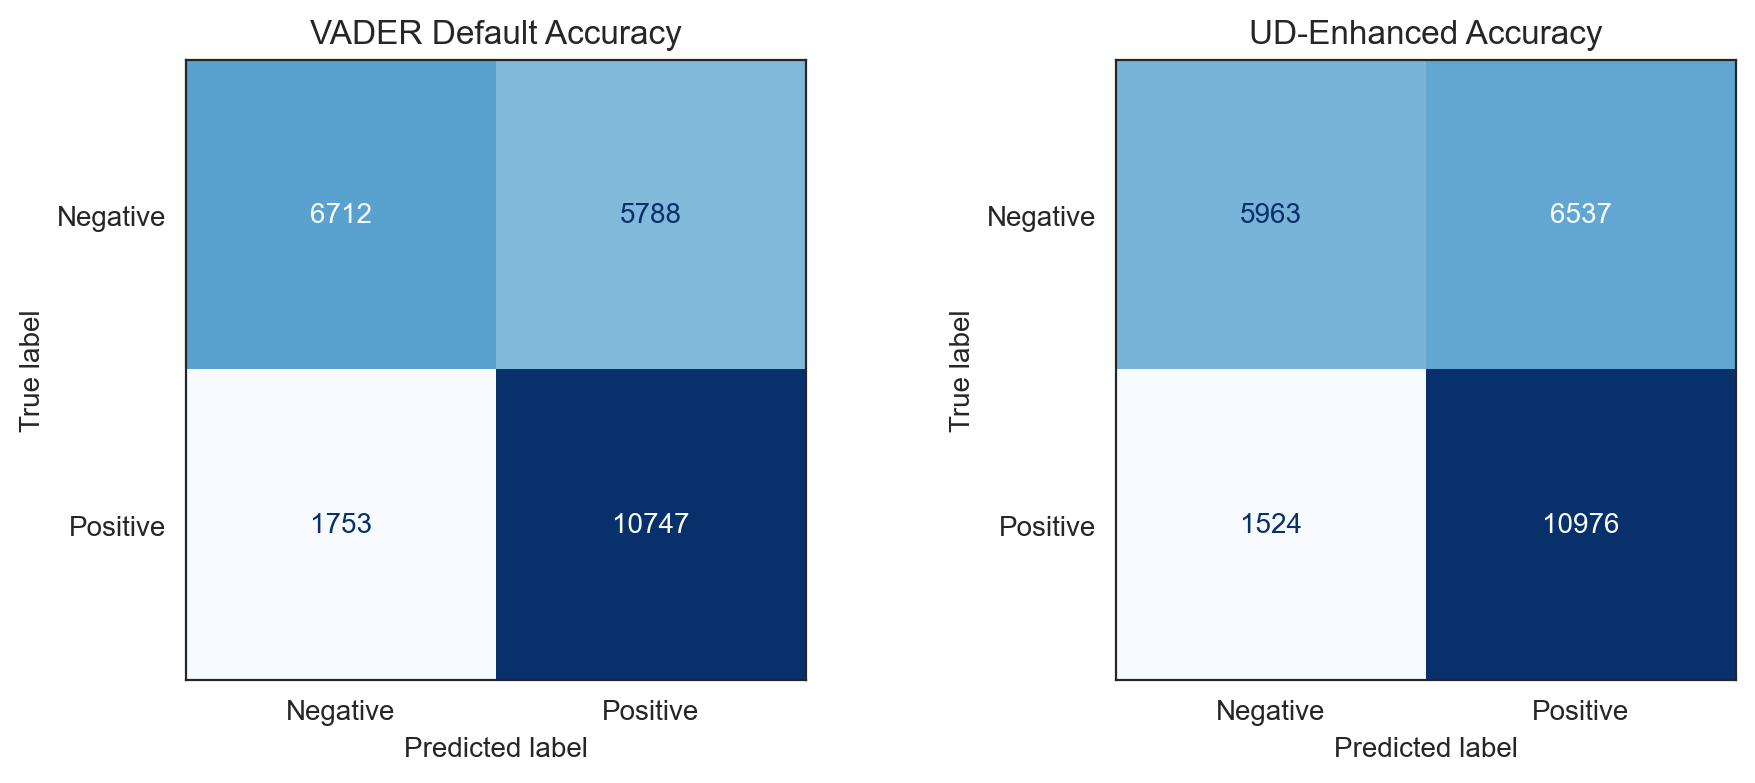

In [110]:
is_pos = lambda x: True if x > 0.0 else False

imdb_vader_scores = list(is_pos(_["compound"]) for _ in imdb_results["Vader"])
imdb_urban_scores = list(is_pos(_["compound"]) for _ in imdb_results["Urban"])
imdb_true_scores = list(is_pos(_) for _ in imdb_results["True"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace = 0.5)
ax1.set_title("VADER Default Accuracy")
ax2.set_title("UD-Enhanced Accuracy")
ConfusionMatrixDisplay.from_predictions(imdb_true_scores, imdb_vader_scores, display_labels=[
                                        "Negative", "Positive"], colorbar=False, cmap="Blues", ax=ax1)
ConfusionMatrixDisplay.from_predictions(imdb_true_scores, imdb_urban_scores, display_labels=[
                                        "Negative", "Positive"],  colorbar=False, cmap="Blues", ax=ax2)

fig.savefig(f"figures/imdb_cmatrix_{lex}.png", bbox_inches='tight')
# TODO: Talk about wrong positive classification (sarcasm heavily influenced?) (will add like 30-50 words)

imdb_df = pd.DataFrame.from_dict(
    {"DVL": [precision_score(imdb_true_scores, imdb_vader_scores, average="binary"), recall_score(imdb_true_scores, imdb_vader_scores, average="binary"), f1_score(imdb_true_scores, imdb_vader_scores, average="binary"), accuracy_score(imdb_true_scores, imdb_vader_scores, normalize=True)],
     "UDL": [precision_score(imdb_true_scores, imdb_urban_scores, average="binary"), recall_score(imdb_true_scores, imdb_urban_scores, average="binary"), f1_score(imdb_true_scores, imdb_urban_scores, average="binary"), accuracy_score(imdb_true_scores, imdb_urban_scores, normalize=True)]},
    orient="index", columns=["Precision", "Recall", "F1 Score", "Accuracy"])

print(imdb_df.style.format(precision=3).to_latex(hrules=True, caption="IMDB Sentiment", label="tab:imdb"))


### GLUE/SST scores

In [75]:
def get_glue_scores(analyzer, urban_analyzer, ds) -> pd.DataFrame:
    results = []
    for row in ds:
        results.append((analyzer.polarity_scores(row["sentence"]), urban_analyzer.polarity_scores(row["sentence"]), row["label"]))
    return pd.DataFrame(results, columns=["Vader", "Urban", "True"])

glue_ds = load_dataset("severo/glue", 'sst2', split="train")
glue_scores = get_glue_scores(analyzer, urban_analyzer, glue_ds)

Found cached dataset glue (/Users/Matey/.cache/huggingface/datasets/severo___glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


\begin{table}
\caption{GLUE SST-2}
\label{tab:glue}
\begin{tabular}{lrrrr}
\toprule
 & Precision & Recall & F1 Score & Accuracy \\
\midrule
DVL & 0.781 & 0.605 & 0.682 & 0.685 \\
UDL & 0.699 & 0.807 & 0.749 & 0.699 \\
\bottomrule
\end{tabular}
\end{table}



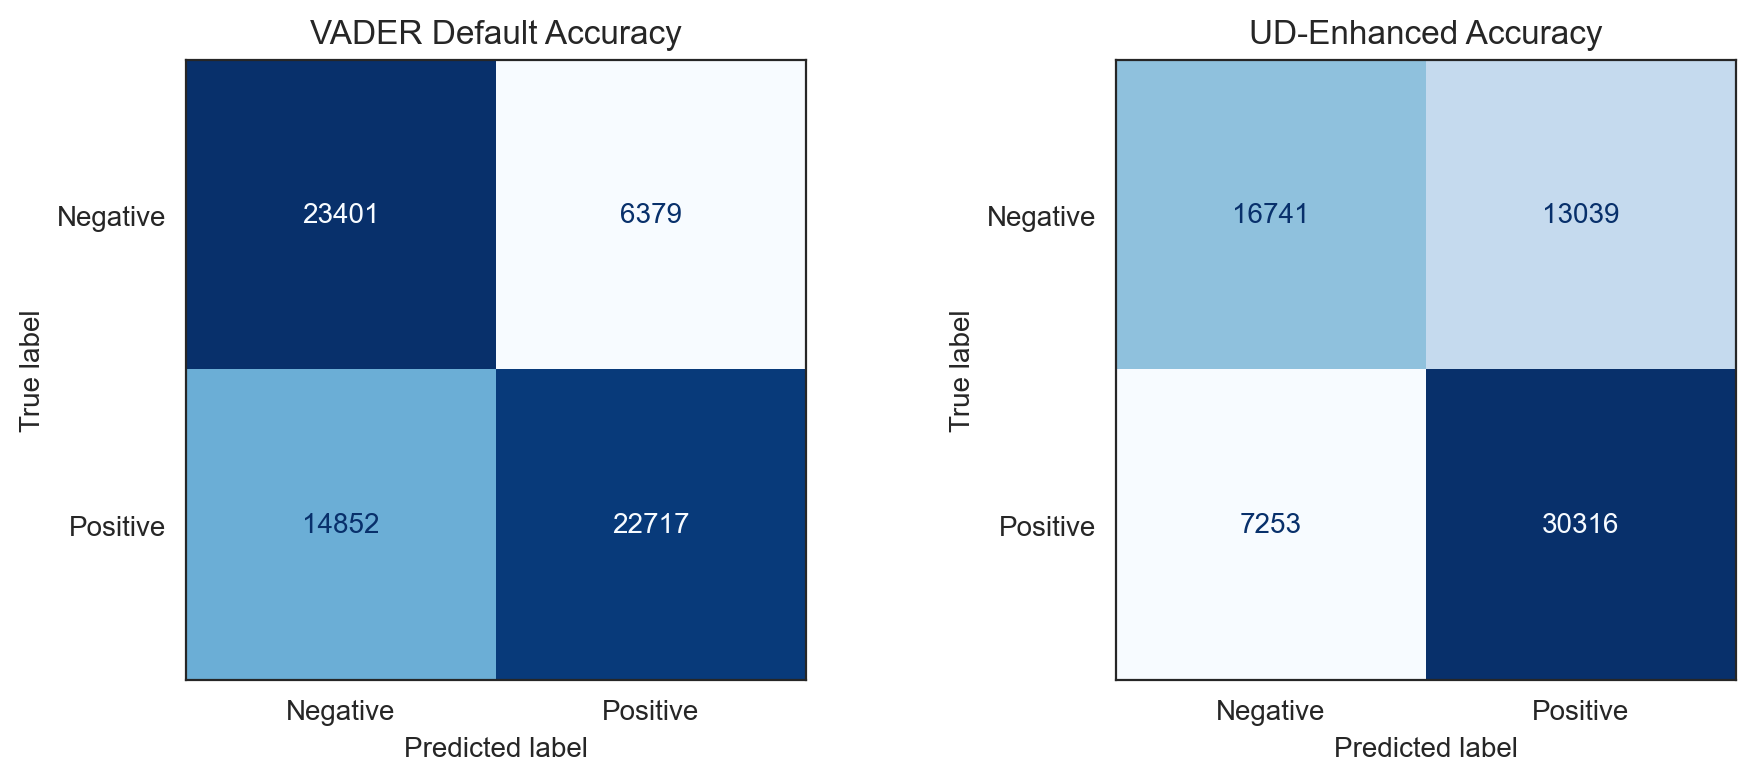

In [111]:
is_pos=lambda x: True if x > 0.0 else False
is_pos_binary=lambda x: True if x == 1 else False

glue_vader_scores=list(is_pos(_["compound"]) for _ in glue_scores["Vader"])
glue_urban_scores=list(is_pos(_["compound"]) for _ in glue_scores["Urban"])
glue_true_scores=list(is_pos_binary(int(_)) for _ in glue_scores["True"])

fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

ax1.set_title("VADER Default Accuracy")
ax2.set_title("UD-Enhanced Accuracy")
ConfusionMatrixDisplay.from_predictions(glue_true_scores, glue_vader_scores, display_labels=[
    "Negative", "Positive"], colorbar=False, cmap="Blues", ax=ax1, values_format="g")
ConfusionMatrixDisplay.from_predictions(glue_true_scores, glue_urban_scores, display_labels=[
    "Negative", "Positive"],  colorbar=False, cmap="Blues", ax=ax2, values_format = "g")
fig.savefig(f"figures/sst2_cmatrix_{lex}.png", bbox_inches='tight')

glue_df = pd.DataFrame.from_dict(
    {"DVL": [precision_score(glue_true_scores, glue_vader_scores, average="binary"), recall_score(glue_true_scores, glue_vader_scores, average="binary"), f1_score(glue_true_scores, glue_vader_scores, average="binary"), accuracy_score(glue_true_scores, glue_vader_scores, normalize=True)],
     "UDL": [precision_score(glue_true_scores, glue_urban_scores, average="binary"), recall_score(glue_true_scores, glue_urban_scores, average="binary"), f1_score(glue_true_scores, glue_urban_scores, average="binary"), accuracy_score(glue_true_scores, glue_urban_scores, normalize=True)]},
    orient="index", columns=["Precision", "Recall", "F1 Score", "Accuracy"])

print(glue_df.style.format(precision=3).to_latex(hrules=True, caption="GLUE SST-2", label="tab:glue"))


### Twitter Sentiment

In [6]:
def get_tweet_scores(analyzer, urban_analyzer, ds) -> pd.DataFrame:
    results = []
    for row in ds:
        if (row["label"] == 1): continue
        results.append((analyzer.polarity_scores(row["text"]), urban_analyzer.polarity_scores(row["text"]), row["label"]))
    return pd.DataFrame(results, columns=["Vader", "Urban", "True"])

twit_ds = load_dataset("tweet_eval", "sentiment", split="train")
twit_scores = get_tweet_scores(analyzer, urban_analyzer, twit_ds)


Found cached dataset tweet_eval (/Users/Matey/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


\begin{table}
\caption{Twitter Sentiment}
\label{tab:twit}
\begin{tabular}{lrrrr}
\toprule
 & Precision & Recall & F1 Score & Accuracy \\
\midrule
DVL & 0.870 & 0.703 & 0.778 & 0.713 \\
UDL & 0.829 & 0.842 & 0.835 & 0.762 \\
\bottomrule
\end{tabular}
\end{table}



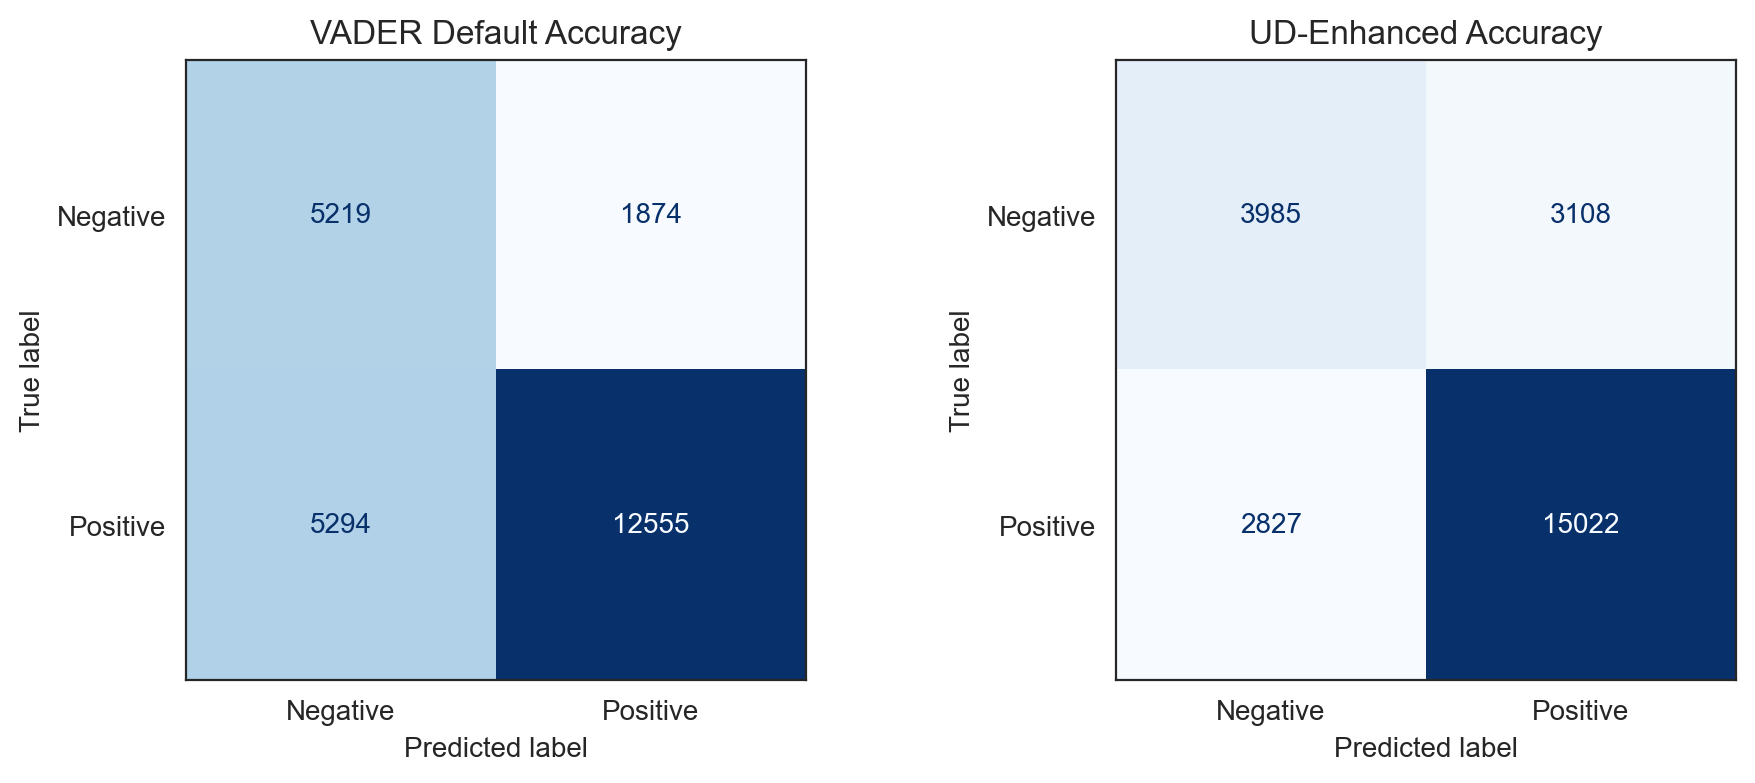

In [121]:
twit_vader_scores = list(is_pos(_["compound"]) for _ in twit_scores["Vader"])
twit_urban_scores = list(is_pos(_["compound"]) for _ in twit_scores["Urban"])
# Discard neutral tweets
twit_true_scores = list(filter(lambda x: x is not None, ([False,None, True][_] for _ in twit_scores["True"])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
# fig.suptitle("Twitter Sentiment")
ax1.set_title("VADER Default Accuracy")
ax2.set_title("UD-Enhanced Accuracy")
ConfusionMatrixDisplay.from_predictions(twit_true_scores, twit_vader_scores, display_labels=[
    "Negative", "Positive"], colorbar=False, cmap="Blues", ax=ax1)
ConfusionMatrixDisplay.from_predictions(twit_true_scores, twit_urban_scores, display_labels=[
    "Negative", "Positive"],  colorbar=False, cmap="Blues", ax=ax2)

fig.savefig(f"figures/twit_cmatrix_{lex}.png", bbox_inches='tight')

twit_df = pd.DataFrame.from_dict(
{"DVL": [precision_score(twit_true_scores, twit_vader_scores, average="binary"), recall_score(twit_true_scores, twit_vader_scores, average="binary"), f1_score(twit_true_scores, twit_vader_scores, average="binary"), accuracy_score(twit_true_scores, twit_vader_scores, normalize=True)],
    "UDL": [precision_score(twit_true_scores, twit_urban_scores, average="binary"), recall_score(twit_true_scores, twit_urban_scores, average="binary"), f1_score(twit_true_scores, twit_urban_scores, average="binary"), accuracy_score(twit_true_scores, twit_urban_scores, normalize=True)]},
     orient="index", columns=["Precision", "Recall", "F1 Score", "Accuracy"])

print(twit_df.style.format(precision=3).to_latex(hrules=True, caption="Twitter Sentiment", label="tab:twit"))